In [1]:
import numpy as np
import os
import argparse
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import cv2
import tensorflow as tf

In [2]:
MODEL_DIR = "../assets/models/"
DATA_DIR = "../assets/data/"
LABELS_FILE = os.path.join(DATA_DIR, "labels.txt")
IMAGES_DIR = os.path.join(DATA_DIR, "samples")

In [3]:
df = pd.read_csv(LABELS_FILE, delim_whitespace=True)
df.head()

,filename,x_centre,y_centre,width,height,confidence
0,sample_0.JPEG,0.832812,0.080220,0.265625,0.182418,1
1,sample_1.JPEG,0.573438,0.295604,0.265625,0.182418,1
2,sample_2.JPEG,0.348438,0.519780,0.265625,0.182418,1
3,sample_3.JPEG,0.000000,0.000000,0.000000,0.000000,0
4,sample_4.JPEG,0.810937,0.941758,0.265625,0.182418,1


In [4]:
data = df.to_numpy()

In [5]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [6]:
def serialize_example(image, image_name, x_center, y_center, confidence):
    """
    Creates a tf.train.Example message ready to be written to a file.
    """
    # Create a dictionary mapping the feature name to the tf.train.Example-compatible
    # data type.
    feature = {
      'image': _bytes_feature(image),
      'image_name': _bytes_feature(image_name),
      'x_center': _float_feature(x_center),
      'y_center': _float_feature(y_center),
      'confidence': _float_feature(confidence)
    }

    # Create a Features message using tf.train.Example.

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [7]:
RECORD_PATH = "../assets/data/records/"
os.makedirs(RECORD_PATH, exist_ok=True)

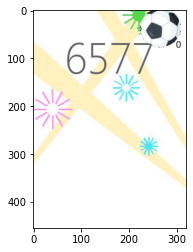

In [12]:
im = cv2.imread("../assets/data/samples/sample_0.JPEG")
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
plt.imshow(im)

In [9]:
RECORD_SIZE = 10000

TOTAL_IMAGES = len(data)
TOTAL_RECORDS = TOTAL_IMAGES // RECORD_SIZE
for i in range(TOTAL_RECORDS):
    print(f'Writing record {i:3d}/{TOTAL_RECORDS}')
    filename = f"images-{i:02d}.tfrec"
    
    record_size = min(RECORD_SIZE, TOTAL_IMAGES-i*RECORD_SIZE)
    
    with tf.io.TFRecordWriter(os.path.join(RECORD_PATH, filename)) as writer:
        for j in range(record_size):
            idx = i*RECORD_SIZE + j
            filename, x_center, y_center, width, height, confidence = data[idx]
            
            img = cv2.imread(os.path.join(IMAGES_DIR, filename))
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
            img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
            
            name = filename.split('.')[0]
            example = serialize_example(
                img, 
                str.encode(name),
                x_center,
                y_center,
                confidence)
            writer.write(example)
            if j % 10 == 0: 
                print(f'image {j:5d}/{RECORD_SIZE}\r', end='')

Writing record 182/200
Writing record 183/200
Writing record 184/200
Writing record 185/200
Writing record 186/200
Writing record 187/200
Writing record 188/200
Writing record 189/200
Writing record 190/200
Writing record 191/200
Writing record 192/200
Writing record 193/200
Writing record 194/200
Writing record 195/200
Writing record 196/200
Writing record 197/200
Writing record 198/200
Writing record 199/200
